In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import sklearn
import random
from unicodedata import normalize
from keras.layers import Dense
from keras import Input
from keras_preprocessing.sequence import pad_sequences 
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 오디오 데이터
DATA_DIR_TRAIN = '/content/drive/My Drive/특화_음성/real_check/train/'
DATA_DIR_TEST = '/content/drive/My Drive/특화_음성/real_check/test/'

In [4]:
train_X = []
train_spectrograms = []
train_mel_spectograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectograms = []
test_mfccs = []
test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것

In [6]:
test_dataset = []
train_dataset = []

frame_length = 0.025
frame_stride = 0.01
sr=16000

input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))
print(input_nfft,input_stride)

400 160


In [7]:
#train data set
for filename in os.listdir(DATA_DIR_TRAIN):
  filename = normalize('NFC', filename) # 'ㅇㅡㅁ.wav' -> '음.wav'
  try:
      
    audio, sr = librosa.load(DATA_DIR_TRAIN + filename, sr=16000)
  
    mfcc = librosa.feature.mfcc(audio, sr=16000, n_mfcc=100, n_fft=input_nfft, hop_length=input_stride)
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 100)

    # 응/아니오 구분하여 dataset에 추가
    if filename[0] == '응':
      train_dataset.append((padded_mfcc, 1))
    else:
      train_dataset.append((padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessin

In [8]:
# test data set
for filename in os.listdir(DATA_DIR_TEST):
  filename = normalize('NFC', filename)
  try:
      
    audio, sr = librosa.load(DATA_DIR_TEST + filename, sr=16000)

    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
  
    mfcc = librosa.feature.mfcc(audio, sr=16000, n_mfcc=100, n_fft=input_nfft, hop_length=input_stride)
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 100)

    # 응/아니 구분하여 dataset에 추가
    if filename[0] == '응':
      test_dataset.append((padded_mfcc, 1))
    else:
      test_dataset.append((padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and mig

In [9]:
# 데이터셋을 셔플
random.shuffle(test_dataset)
random.shuffle(train_dataset)

train_mfccs = [a for (a,b) in train_dataset]
train_y = [b for (a,b) in train_dataset]

test_mfccs = [a for (a,b) in test_dataset]
test_y = [b for (a,b) in test_dataset]

train_mfccs = np.array(train_mfccs)
train_y = tf.keras.utils.to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = tf.keras.utils.to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)
print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

train_mfccs: (270, 100, 100)
train_y: (270, 2)
test_mfccs: (30, 100, 100)
test_y: (30, 2)


In [10]:
# MFCC feature로 학습
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (270, 100, 100, 1)
test X shape: (30, 100, 100, 1)


In [11]:
ip = Input(shape=train_X_ex[0].shape)

m = tf.keras.layers.Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
#m = tf.keras.layers.BatchNormalization()(m)
m = tf.keras.layers.MaxPooling2D(pool_size=(4,4))(m)

m =tf.keras.layers.Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
#m = tf.keras.layers.BatchNormalization()(m)
m = tf.keras.layers.MaxPooling2D(pool_size=(4,4))(m)

m = tf.keras.layers.Conv2D(32*3, kernel_size=(4,4), activation='relu')(ip)
#m = tf.keras.layers.BatchNormalization()(m)
m = tf.keras.layers.MaxPooling2D(pool_size=(4,4))(m)

m = tf.keras.layers.Flatten()(m)

m = Dense(32)(m)
#m = tf.keras.layers.BatchNormalization()(m)
m = tf.keras.layers.Activation("relu")(m)

op = Dense(2, activation='softmax')(m)

model = tf.keras.Model(ip, op)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 97, 96)        1632      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 96)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 55296)             0         
                                                                 
 dense (Dense)               (None, 32)                1769504   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                             

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/100
9/9 [==============================] - 4s 332ms/step - loss: 5.1250 - accuracy: 0.5074 - val_loss: 1.0555 - val_accuracy: 0.5000
Epoch 2/100
9/9 [==============================] - 3s 303ms/step - loss: 1.5169 - accuracy: 0.5111 - val_loss: 1.0629 - val_accuracy: 0.5000
Epoch 3/100
9/9 [==============================] - 3s 309ms/step - loss: 0.8595 - accuracy: 0.5296 - val_loss: 0.7477 - val_accuracy: 0.4667
Epoch 4/100
9/9 [==============================] - 3s 302ms/step - loss: 0.6662 - accuracy: 0.6222 - val_loss: 0.9815 - val_accuracy: 0.5000
Epoch 5/100
9/9 [==============================] - 3s 304ms/step - loss: 0.6303 - accuracy: 0.6519 - val_loss: 0.6561 - val_accuracy: 0.5667
Epoch 6/100
9/9 [==============================] - 3s 303ms/step - loss: 0.4427 - accuracy: 0.8778 - val_loss: 0.6415 - val_accuracy: 0.6333
Epoch 7/100
9/9 [==============================] - 3s 306ms/step - loss: 0.4284 - accuracy: 0.8296 - val_loss: 0.7019 - val_accuracy: 0.5000
Epoch 8/100
9

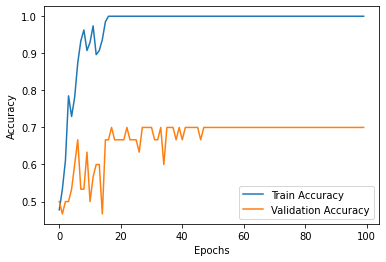

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [26]:
# 샘플 오디오 데이터
DATA_DIR = '/content/drive/My Drive/특화_음성/tutorial/'

wav, sr = librosa.load(DATA_DIR + 'sample_5(안녕).wav', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 44100
wav shape: (90317,)
length: 2.0480045351473923 secs


In [28]:
mfcc = librosa.feature.mfcc(wav, n_mfcc=100)
padded_mfcc = pad2d(mfcc, 300)
padded_mfcc = np.expand_dims(padded_mfcc, 0)

result = model.predict(padded_mfcc)
print(result)
if result[0][0] <= result[0][1]: # 인사
  print('인사') 
else:
  print('인사 아님')

[[1. 0.]]
인사 아님


In [16]:
model.save('/content/drive/My Drive/졸프/0726Data/filler_determine_model_by_train2_1205.h5')